# Unsupervised learning
[]()

In [4]:
import pandas as pd
import sys
sys.path.append(r"C:\Users\silvh\OneDrive\lighthouse\custom python")
from silvhua import *
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression, SelectKBest

from sklearn.cluster import KMeans

import scipy.cluster.hierarchy as sch
import numpy as np
from sklearn.cluster import AgglomerativeClustering

In [35]:
from sklearn.decomposition import PCA 

## *Load data*

In [144]:
flights = load_csv2(r'C:\Users\silvh\OneDrive\lighthouse\projects\midterm-2022-10-24\data\experimentation',
    'flights_cleaned_no_outliers_2022-10-26_1451.csv',column1_as_index=True, truncate=5000)
flights.head()

,op_carrier_fl_num,origin_airport_id,dest_airport_id,dep_delay,arr_delay,crs_dep_time,crs_arr_time,crs_elapsed_time,actual_elapsed_time,air_time,...,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,haul_length_long,haul_length_medium,haul_length_short
1664,1664,14082,14108,-10.0,-13.0,820,1006,166,163.0,150.0,...,0,0,0,0,0,1,0,0,0,1
3359,3359,14893,14747,-7.0,31.0,1040,1250,130,168.0,103.0,...,0,0,0,0,0,1,0,0,0,1
510,510,13796,12892,-10.0,-10.0,2055,2221,86,86.0,55.0,...,0,0,1,0,0,0,0,0,0,1
3046,3046,12892,15376,-8.0,-10.0,2002,2129,87,85.0,62.0,...,1,0,0,0,0,0,0,0,0,1
27,27,11259,12191,4.0,7.0,1300,1410,70,73.0,51.0,...,0,0,0,0,1,0,0,0,0,1


In [145]:
columns_to_exclude = ['day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'haul_length_long', 'haul_length_medium', 'haul_length_short']

columns_for_ID = ['op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id']

### Drop columns and split into X and y

In [146]:
# Drop columns and split into X and y
ID_columns = flights[columns_for_ID].copy()
y = flights['arr_delay']
flights.drop(labels='arr_delay', inplace=True, axis=1)
flights.drop(labels=columns_to_exclude, inplace=True, axis=1)
flights.drop(labels=columns_for_ID, inplace=True, axis=1)
flights.columns

Index(['dep_delay', 'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'distance', 'month', 'fl_date_year',
       'fl_date_week_number', 'mean_dep_delay_carrier_origin_month',
       'mean_arr_delay_carrier_origin_month',
       'mean_dep_delay_carrier_origin_week',
       'mean_arr_delay_carrier_origin_week',
       'mean_dep_delay_carrier_origin_date',
       'mean_arr_delay_carrier_origin_date',
       'mean_dep_delay_carrier_origin_date_t-1_week',
       'mean_arr_delay_carrier_origin_date_t-1_week',
       'mean_dep_delay_carrier_origin_date_t-1_week_week_number',
       'mean_arr_delay_carrier_origin_date_t-1_week_week_number',
       'origin_region_Midwest', 'origin_region_Northeast',
       'origin_region_South', 'origin_region_West', 'dest_region_Midwest',
       'dest_region_Northeast', 'dest_region_South', 'dest_region_West',
       'arr_hrs_ctg_Afternoon', 'arr_hrs_ctg_Evening', 'arr_hrs_ctg_Morning',
       'arr_hrs_ctg_Night', '

In [147]:
ID_columns.columns

Index(['op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id'], dtype='object')

## *Finding number of clusters*

### Previous scripts as templates

In [148]:
# # define plot_dendrogram function
# def plot_dendrogram(X,method ='ward'):
#     dendrogram = sch.dendrogram(sch.linkage(X, method=method))
#     plt.title("Dendrogram")
#     plt.ylabel("Euclidean distances")
#     plt.xlabel('Points')
#     plt.show()

# # Distortion
# def plot_distortion(X,max_clusters = 10):
#     """
#     Create a plot to help identify the elbow of the inertia graph.
#     Parameter:
#     - X: Array of the data. Use `.to_numpy()` method to convert dataframe to array if needed.
#     """
#     distortions = []
#     for i in range(1, max_clusters +1):
#         km = KMeans(n_clusters=i,
#                     init='k-means++',
#                     n_init=10,
#                     random_state=0)
#         km.fit(X)
#         distortions.append(km.inertia_) # Calcuate the distortion for a given number of clusters

#     plt.plot(range(1,max_clusters +1), distortions, marker='o')
#     plt.xlabel('Number of clusters')
#     plt.ylabel('Distortion')
#     plt.show() 

### *V1*

In [149]:
# define plot_dendrogram function
def find_clusters(X,method ='ward',max_clusters = 4, dendogram=False):
    """
    Create a plot to help identify the elbow of the inertia graph.
    Parameter:
    - X: Array of the data. Use `.to_numpy()` method to convert dataframe to array if needed.
    """
    from sklearn.cluster import KMeans
    import scipy.cluster.hierarchy as sch

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

    # Dendogram
    if dendogram:
        dendrogram = sch.dendrogram(sch.linkage(X, method=method), ax=ax[0])
        plt.title("Dendrogram")
        plt.ylabel("Euclidean distances")
        plt.xlabel('Points')

    # KMeans clusters
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_) # Calcuate the distortion for a given number of clusters

    ax[1].plot(range(1,max_clusters +1), distortions, marker='o')
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('Distortion')

    plt.show() 

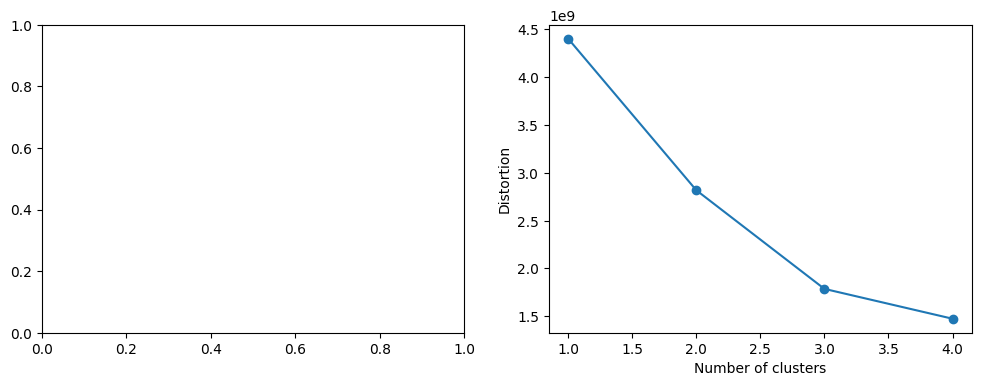

In [158]:
# plot dendogram and KMeans distortions
find_clusters(flights,dendogram=False)

In [159]:
def kmeans_ac(df,n_clusters):
    """
    Perform KMeans and agglomerative clustering and add the results to the dataframe
    as new columns.
    Plots a heatmap to compare classification between the two methods.

    Parameters:
    df: Dataframe.
    n_clusters: Number of clusters.
    """
    import seaborn as sns

    # KMeans Clustering and agglomerative clustering
    km = KMeans(n_clusters=n_clusters, # how many clusters we expected 
                n_init=20, # how many initial runs
                random_state=0) # set the random_state parameter to easily reproduce the results.

    # Train the model
    km.fit(df)

    # predict (the cluster to which a given point will belong)
    y_km = km.predict(df)
    df['y_km'] = y_km

    # aglomerative clustering
    ac = AgglomerativeClustering(affinity='euclidean', 
                linkage='ward', #set the `linkage` parameter to the "ward"
                n_clusters = n_clusters) # set the number of clusters to three.

    # fit and predict 
    y_ac = ac.fit_predict(df)
    df['y_ac'] = y_ac

    # Compare clustering algorithm results
    # Step 1: Create table showing counts for each KMeans and Agglomerative Clustering cluster assignment.
    clusterComparison = pd.DataFrame(df['y_km']).merge(pd.get_dummies(df['y_ac']),
        how='outer',right_index=True,left_index=True
        ).groupby('y_km').sum()
    clusterComparison_percent = clusterComparison/clusterComparison.sum()

    # # Step 2: 
    sns.heatmap(clusterComparison_percent,annot=True,fmt='.1%')
    plt.title('KMeans Clustering vs. Agglomerative Clustering Assignment')
    return df


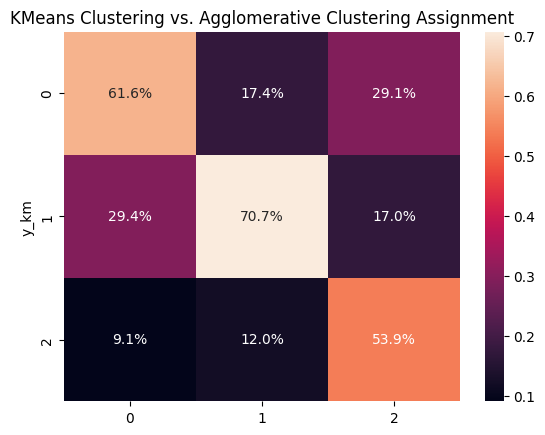

In [160]:
n_clusters = 3

flights = kmeans_ac(flights,n_clusters)

## *PCA*

In [161]:
flights.columns

Index(['dep_delay', 'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'distance', 'month', 'fl_date_year',
       'fl_date_week_number', 'mean_dep_delay_carrier_origin_month',
       'mean_arr_delay_carrier_origin_month',
       'mean_dep_delay_carrier_origin_week',
       'mean_arr_delay_carrier_origin_week',
       'mean_dep_delay_carrier_origin_date',
       'mean_arr_delay_carrier_origin_date',
       'mean_dep_delay_carrier_origin_date_t-1_week',
       'mean_arr_delay_carrier_origin_date_t-1_week',
       'mean_dep_delay_carrier_origin_date_t-1_week_week_number',
       'mean_arr_delay_carrier_origin_date_t-1_week_week_number',
       'origin_region_Midwest', 'origin_region_Northeast',
       'origin_region_South', 'origin_region_West', 'dest_region_Midwest',
       'dest_region_Northeast', 'dest_region_South', 'dest_region_West',
       'arr_hrs_ctg_Afternoon', 'arr_hrs_ctg_Evening', 'arr_hrs_ctg_Morning',
       'arr_hrs_ctg_Night', '

In [167]:
# Perform PCA
def run_pca(df, n_components=2, column_range=(0,-2), cluster_col=(-2,-1)):
    """
    Run a PCA, then plot data along the first 2 PC dimensions and the projections.
    Parameters: 
    - columns: Start and end index for column numbers to include in the model.
        Default assumes that last 2 columns are to be excluded because they
        contain the cluster numbers.
        Specify 'None' to include all columns.
    - cluster_col: Column(s) with cluster ids.

    """
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    import seaborn as sns

    pca = PCA(n_components=n_components)
    if column_range == None:
        columns = df.columns
    else:
        columns = df.columns[column_range[0]:column_range[1]]
    data = df[columns]

    # Scale the data
    scaler = StandardScaler() 
    data_scaled = pd.DataFrame(scaler.fit_transform(data))
    
    # Apply PCA
    pca.fit(data_scaled)
    data_pca = pca.transform(data_scaled)
    data_pca = pd.DataFrame(data_pca)

    # Get the projections ('loadings') of each dimension along each principal component:
    loadings = pd.DataFrame(pca.components_)

    # rename the columns from the PCA dataframe result
    loadings.columns = columns

    # plot PCA showing both KMeans clusters and AC clusters
    # To plot the raw data along with the loading plot, scale the raw data down:
    xscale = 1/(data_pca[0].max()-data_pca[0].min())
    yscale = 1/(data_pca[1].max()-data_pca[1].min())
    # Make the plots
    fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(12,5))

    # Plot showing KMeans clusters
    if cluster_col:
        clustering_col1 = df.columns[cluster_col[0]]
        clustering_col2 = df.columns[cluster_col[-1]]

        sns.scatterplot(
            x=data_pca[0]*xscale,y=data_pca[1]*yscale,
            hue=df[clustering_col1].values,
            ax=ax[0]
            )
        for feature, vector in loadings.items():
            # Plot each feature using the two principal components as axes
            ax[0].arrow(0,0,vector[0],vector[1]) 
            # Label each arrow at the tip of the line
            if (vector[0] > loadings.loc[0,:].mean()) | (vector[1] > loadings.loc[1,:].mean()):
                ax[0].text(vector[0],vector[1],feature)
        ax[0].set_xlabel('PC1')
        ax[0].set_ylabel('PC2')
        ax[0].set_title(clustering_col1)

        # Plot showing AC clusters
        sns.scatterplot(
            x=data_pca[0]*xscale,y=data_pca[1]*yscale,
            hue=df[clustering_col2].values,
            ax=ax[1]
            )
        for feature, vector in loadings.items():
            # Plot each feature using the two principal components as axes
            ax[1].arrow(0,0,vector[0],vector[1]) 
            # Label each arrow at the tip of the line
            if (vector[0] > loadings.loc[0,:].mean()) | (vector[1] > loadings.loc[1,:].mean()):
                ax[1].text(vector[0],vector[1],feature)
        ax[1].set_xlabel('PC1')
        ax[1].set_ylabel('PC2')
        ax[1].set_title(clustering_col2)


    return data_pca

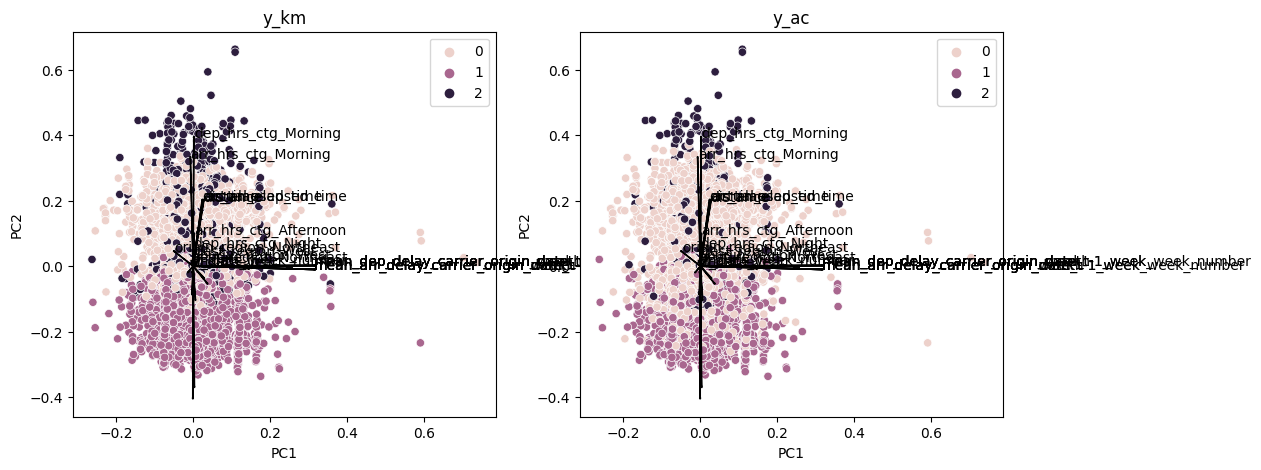

In [168]:
df = flights.copy(deep=False)
pca = run_pca(df, column_range=(0,-2), n_components=2)

In [169]:
pca.columns[-1]

1

In [170]:
flights

,dep_delay,crs_dep_time,crs_arr_time,crs_elapsed_time,actual_elapsed_time,air_time,distance,month,fl_date_year,fl_date_week_number,...,arr_hrs_ctg_Afternoon,arr_hrs_ctg_Evening,arr_hrs_ctg_Morning,arr_hrs_ctg_Night,dep_hrs_ctg_Afternoon,dep_hrs_ctg_Evening,dep_hrs_ctg_Morning,dep_hrs_ctg_Night,y_km,y_ac
1664,-10.0,820,1006,166,163.0,150.0,1045,3,2019,11,...,0,0,1,0,0,0,1,0,0,0
3359,-7.0,1040,1250,130,168.0,103.0,605,3,2019,11,...,1,0,0,0,0,0,1,0,0,0
510,-10.0,2055,2221,86,86.0,55.0,337,3,2019,11,...,0,1,0,0,0,1,0,0,1,1
3046,-8.0,2002,2129,87,85.0,62.0,451,3,2019,12,...,0,1,0,0,0,1,0,0,1,1
27,4.0,1300,1410,70,73.0,51.0,239,3,2019,11,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,-1.0,905,1729,324,327.0,287.0,2521,3,2019,13,...,0,1,0,0,0,0,1,0,2,2
1342,-5.0,500,614,74,64.0,42.0,237,3,2019,13,...,0,0,1,0,0,0,1,0,0,0
1209,8.0,2142,527,285,248.0,231.0,2267,3,2019,13,...,0,0,1,0,0,1,0,0,2,2
434,4.0,800,1045,105,86.0,75.0,632,3,2019,11,...,0,0,1,0,0,0,1,0,0,0


# *End of Page*